In [1]:
#User Data
## User Location Distribution
import numpy as np
import math
import matplotlib.pyplot as plt
import cmath
Num_User = 400
Num_BS_antenna = 64

class User_Location_Generator:
    def __init__(self, num_Users, region_type = 'square', distribution_type = 'random'):
        self.Num_users = num_Users
        self.Region_type = region_type # ['circle','square']
        self.Distribution_type = distribution_type #['uniform','random']
        self.BS_location = np.asarray([0,0,10])
        self.User_location = np.zeros((self.Num_users,3))
        self.length  = 200 # (half length of edge) or  (radius of circle)
        if self.Region_type == 'square':
            if self.Distribution_type == 'random':
                self.User_location += np.random.rand(self.Num_users,3)*self.length*2
                self.User_location[:,2] = 0
                self.User_location[:,0] -= self.length
            elif self.Distribution_type == 'uniform':
                self.Num_users = 400
                l = int(math.sqrt(self.Num_users))
                x = np.linspace(0,self.length,l)
                y = np.linspace(0,self.length,l)
                
                #x = np.random.randint(0,self.length/10+1,(self.Num_users))*20 
                #y = np.random.randint(0,self.length/10+1,(self.Num_users))*20  
                X, Y = np.meshgrid(x, y)
                X = X.flatten()
                Y =Y.flatten()
                print(x.shape)
                self.User_location[:,0] = X
                self.User_location[:,1] = Y
                self.User_location[:,0] -= self.length
        elif self.Region_type == 'circle':
            if self.Distribution_type == 'random':
                r = np.random.rand(self.Num_users)*self.length # radius
                d = np.random.rand(self.Num_users)*2*math.pi # degrees
                self.User_location[:,0] = np.cos(d)*r
                self.User_location[:,1] = np.sin(d)*r
            elif self.Distribution_type == 'uniform':
                r = np.random.randint(0,self.length/20+1,(self.Num_users))*20# radius
                d = np.random.randint(0,33,(self.Num_users))/32*2*math.pi # degrees
                self.User_location[:,0] = np.cos(d)*r
                self.User_location[:,1] = np.sin(d)*r




In [2]:
class Channel_Model:
    
    def __init__(self,BS_Location,UE_Location,Num_BS_antenna = 64):
        self.BS_coordinates = BS_Location
        self.UE_coordinates = UE_Location
        self.Distance = self.UE_coordinates-self.BS_coordinates
        self.Distance_2 = np.sqrt(np.mean(np.power(self.UE_coordinates-self.BS_coordinates,2)))
        
        self.AoA = self.AoA_at_BS() # return array ([AoA_azimuth,AoA_elevation])
        self.frequency = 60e9 # GHz
        self.frequency_spacing = 15e3 # kHz
        self.c = 300000000 #
        self.wavelength = self.c/self.frequency
        # In general, the frenquency of one sub-carrier bandwidth is flat fading 
        # So the delay time of each path should less then the max delay time
        self.Maxmum_delay_time = 1/self.frequency_spacing 
        self.Num_clusters = 5
        self.Num_path = 5
        self.Num_delay_tap = self.Num_path
        self.Num_Tx = 1
        self.Num_Rx = Num_BS_antenna
        
        self.Num_Subcarriers = 1
        self.Ts = 1/self.frequency/2.0 # Sampled Period 
        
        self.delta_dis=np.random.random((self.Num_clusters))*self.Distance_2
        self.AoA_all_path = np.random.random((self.Num_clusters,2))*math.pi*0.5 - math.pi*0.25+self.AoA
        self.steering = np.zeros((int(math.sqrt(Num_BS_antenna)),int(math.sqrt(Num_BS_antenna))))
        self.frequency_selective_channel = self.channel()
        
    def AoA_at_BS(self):
        distance = self.Distance
        AoA_azimuth = math.degrees(math.atan2(distance[1],distance[0]))
        AoA_elevation = 90 + math.degrees(math.atan2(distance[1],math.sqrt(distance[0]**2+distance[1]**2)))
        return np.asarray([AoA_azimuth,AoA_elevation])
    def time_delay(self): # time delay for each path each cluster.
        #tau_l = np.random.random(self.Num_clusters)*self.Maxmum_delay_time
        #tau_l[0] = 0
        #return tau_l
        #for index in range(self.Num_clusters):
        #    if index == 0:
        #        tau_l[index] = 0
        #    else:
        #        tau_l[index] = self.Maxmum_delay_time*1.9/index
        tau_l = self.delta_dis/self.c
        tau_l[0] = 0
        return tau_l
    def complex_path_gain(self): # alpha l, complex channel gain for each path each cluster.
        #dB
        alpha = np.zeros((self.Num_clusters))+1j*np.zeros((self.Num_clusters))
        for index_gains in range(self.Num_clusters):
            #if index_gains == 0:
             #   alpha[index_gains] = 0
            #else:
            alpha[index_gains] = self.wavelength/(4*math.pi*(self.Distance_2+self.delta_dis[index_gains]))*math.sqrt(self.Num_Rx*self.Num_Tx)*\
                np.exp(-1j*2*math.pi*(self.Distance_2+self.delta_dis[index_gains])/self.wavelength)#(np.random.randn(1)+1j*np.random.randn(1))*(self.Num_path)
                #alpha[index_gains] = alpha[index_gains-1]-1
        #alpha=np.power(10,alpha/10)
        return alpha
    def Path_loss(self):
        pathLoss = np.zeros((self.Num_path))
        for index_path in range(self.Num_path):
            
            if index_path == 0:
                pathLoss[index_path] = 32.4+21.6*math.log10(math.sqrt(np.sum(np.power(self.Distance,2))))+\
                20*math.log10(self.frequency)+1.7 
            else:
                pathLoss[index_path] = 32.4+27.6*math.log10(self.Distance_2+self.delta_dis[index_path])+\
                20*math.log10(self.frequency)+6.7
        #dB2power
        pathLoss = np.power(10,pathLoss/10)
        return pathLoss

    def UPA(self,Num_Antennas,Angle):
        N_x = N_z = int(math.sqrt(Num_Antennas))
        a_x = np.zeros((N_x,1),dtype=np.complex128)
        a_z = np.zeros((N_z,1),dtype=np.complex128)
        for index_antennas in range(N_x):
            #print('index',index_antennas,'angle',Angle)
            a_x[index_antennas] = np.exp(1j*(index_antennas)*\
                                         (math.pi * math.sin(math.radians(Angle[1]))*\
                                          math.cos(math.radians(Angle[0]))))
            a_z[index_antennas] = np.exp(1j*(index_antennas)*(math.pi * math.cos(math.radians(Angle[1]))))
        a_x = 1/np.sqrt(N_x) * a_x
        a_z = 1/np.sqrt(N_z) * a_z
        a = np.kron(a_z,a_x)
        return a
    def channel(self):
        H = np.zeros((self.Num_Subcarriers,self.Num_Rx,self.Num_Tx,self.Num_delay_tap))+\
            1j*np.zeros((self.Num_Subcarriers,self.Num_Rx,self.Num_Tx,self.Num_delay_tap))
        # (Num_CS,Num_Rx,Num_Tx,Num_Delay_tap)
        h_d =np.zeros((self.Num_Rx,self.Num_Tx,self.Num_delay_tap),dtype=np.complex128)
        # (Num_Rx,Num_Tx,Num_Delay_tap)
        
        
        at = self.UPA(self.Num_Rx,self.AoA)
        self.steering = at
        alphal = self.complex_path_gain()
        pathLoss = self.Path_loss()
        for index_Num_clusters in range(self.Num_clusters):
            time_delay = self.time_delay()
            for index_Num_delay in range(self.Num_path):
                if index_Num_delay >= 1:
                    pathLoss = self.Path_loss()+np.random.randn(1)*index_Num_delay
                    alphal = self.complex_path_gain()-np.random.randn(1)*index_Num_delay
                    at = self.UPA(self.Num_Rx,self.AoA_all_path[index_Num_clusters]+np.random.randn(2)*index_Num_delay)
                # the d-th delay tap ([Num_Rx, Num_Tx, Num_delay])
                h_d[:,:,index_Num_clusters] += alphal[index_Num_delay]*np.sinc(index_Num_clusters*\
                    self.Ts-time_delay[index_Num_delay])*at
            h_d[:,:,index_Num_clusters] = math.sqrt(self.Num_Tx/(pathLoss[index_Num_clusters]*self.Num_clusters))*\
            h_d[:,:,index_Num_clusters]
            for index_Num_subcarriers in range(self.Num_Subcarriers):
                H[index_Num_subcarriers,:,:,:] += h_d*\
                                cmath.exp(-1j*2*math.pi*index_Num_subcarriers*index_Num_clusters/(self.Num_Subcarriers*\
                                    (index_Num_subcarriers+1)))
        return H

(20,)


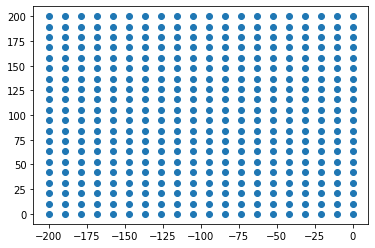

check shape (400, 3) (400, 3)


In [3]:
# generate User location
# if select 'uniform', the output is 20x20 user metrix, whatever the input Num_User.
UL = User_Location_Generator(Num_User,region_type = 'square', distribution_type = 'uniform')
BS_Location = UL.BS_location
BS_Location = np.tile(np.expand_dims(BS_Location,0),[Num_User,1])
UE_Location = UL.User_location
plt.scatter(UE_Location[:,0],UE_Location[:,1])
plt.show()
print('check shape',BS_Location.shape,UE_Location.shape)

In [4]:
# generate channel 4 x 4
channel_4x4 = np.zeros((Num_User,4,4),dtype = np.complex128)
Beam_4x4 = np.zeros((Num_User,4,4),dtype = np.complex128)
for index_ue in range(Num_User):
    CM_4x4 = Channel_Model(BS_Location[index_ue,:],UE_Location[index_ue,:],16) 
    channel = np.squeeze(np.sum(CM_4x4.frequency_selective_channel,3)).reshape(4,4)
    channel_4x4[index_ue,:] = channel
    Beam_4x4[index_ue,:] = CM_4x4.steering.reshape(4,4)
# generate channel 8 x 8
channel_8x8 = np.zeros((Num_User,8,8),dtype = np.complex128)
Beam_8x8 = np.zeros((Num_User,8,8),dtype = np.complex128)
for index_ue in range(Num_User):
    CM_8x8 = Channel_Model(BS_Location[index_ue,:],UE_Location[index_ue,:],64) 
    channel = np.squeeze(np.sum(CM_8x8.frequency_selective_channel,3)).reshape(8,8)
    channel_8x8[index_ue,:] = channel
    Beam_8x8[index_ue,:] = CM_8x8.steering.reshape(8,8)
# generate channel 16 x 16
channel_16x16 = np.zeros((Num_User,16,16),dtype = np.complex128)
Beam_16x16 = np.zeros((Num_User,16,16),dtype = np.complex128)
for index_ue in range(Num_User):
    CM_16x16 = Channel_Model(BS_Location[index_ue,:],UE_Location[index_ue,:],256) 
    channel = np.squeeze(np.sum(CM_16x16.frequency_selective_channel,3)).reshape(16,16)
    channel_16x16[index_ue,:] = channel
    Beam_16x16[index_ue,:] = CM_16x16.steering.reshape(16,16)
    



location : [-200.    0.    0.]


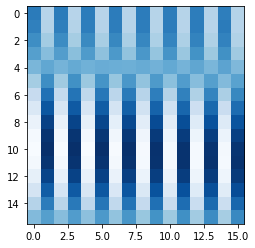

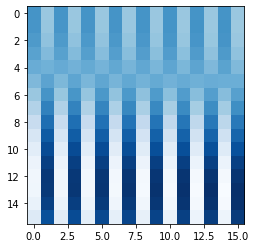

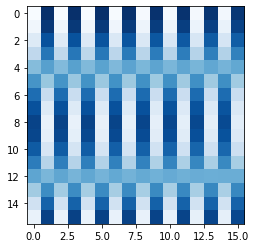

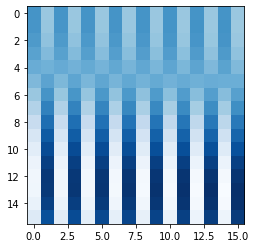

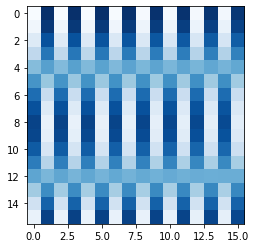

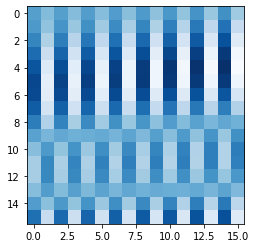

In [5]:
idx = 0
plt.figure()
plt.imshow(np.real(channel_4x4[idx]), cmap='Blues')
plt.imshow(np.real(channel_8x8[idx]), cmap='Blues')
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+1]),cmap = 'Blues')
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+2]),cmap = 'Blues')
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+3]),cmap = 'Blues')

#
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+1]),cmap = 'Blues')
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+2]),cmap = 'Blues')
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(channel_16x16[idx+0])-np.real(channel_16x16[idx+3]),cmap = 'Blues')


location : [-189.47368421    0.            0.        ]


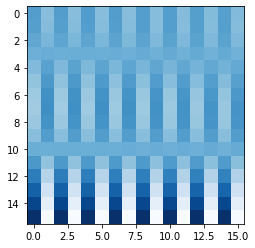

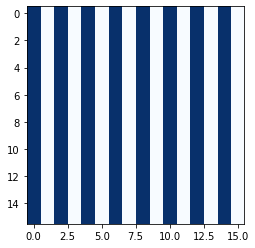

In [6]:
idx = 1
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-178.94736842    0.            0.        ]


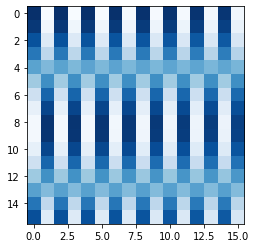

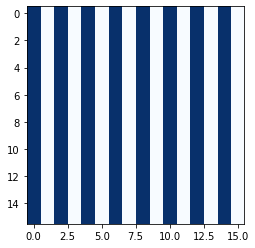

In [7]:
idx = 2
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-147.36842105    0.            0.        ]


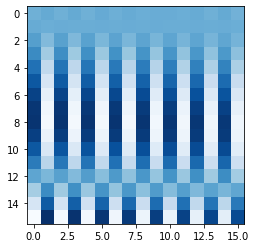

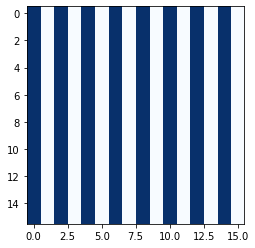

In [8]:
idx = 5
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-94.73684211   0.           0.        ]


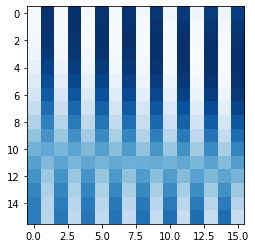

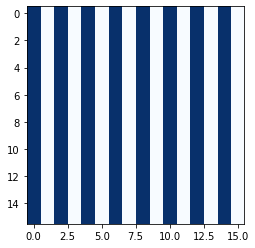

In [9]:
idx = 10
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-42.10526316   0.           0.        ]


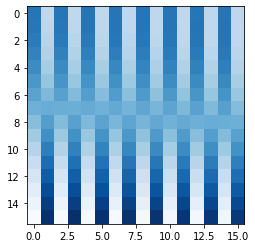

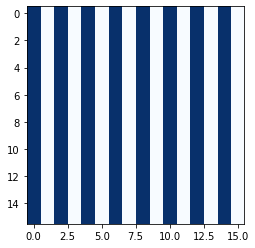

In [10]:
idx = 15
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-94.73684211  21.05263158   0.        ]


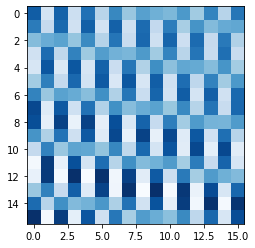

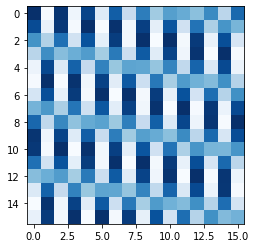

In [11]:
idx = 50
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-42.10526316 126.31578947   0.        ]


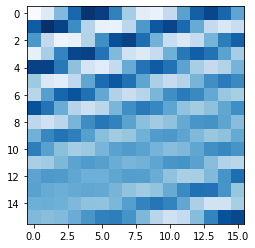

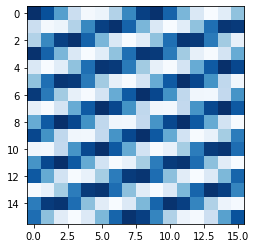

In [12]:
idx = 16*16-1
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-52.63157895 126.31578947   0.        ]


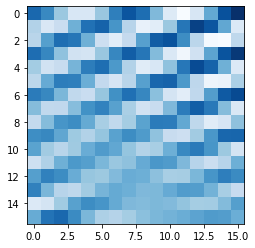

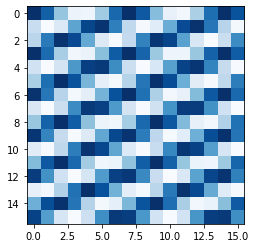

In [13]:
idx = 16*16-2
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-200.          126.31578947    0.        ]


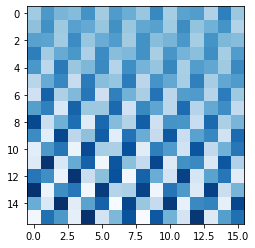

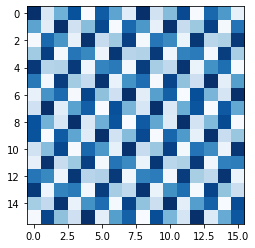

In [14]:
idx = 16*16-16
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-115.78947368   63.15789474    0.        ]


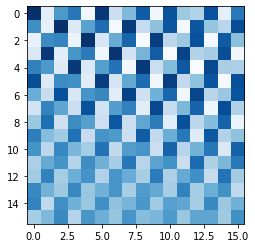

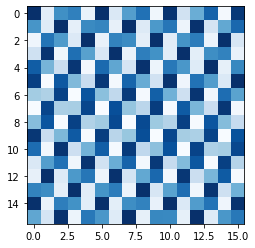

In [15]:
idx = int(16*16/2)
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

location : [-73.68421053  52.63157895   0.        ]


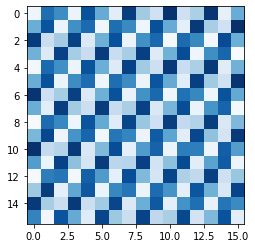

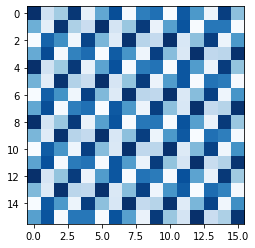

In [16]:
idx = int(16*16/2)-16
plt.figure()
plt.imshow(np.real(channel_16x16[idx]),cmap = 'Blues')
print('location :', UE_Location[idx])
plt.figure()
#print('steering',CM_16x16.steering.shape)
plt.imshow(np.real(Beam_16x16[idx]),cmap = 'Blues')

# Below is the test case of WirelessInSite #m

In [17]:
file_a = np.load('./channel data/256-01.npy')

In [18]:
file_a[0].shape

(1, 256)

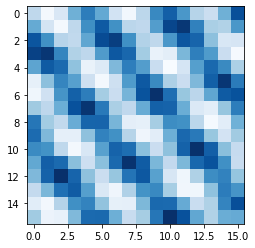

In [19]:
a = file_a[0].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

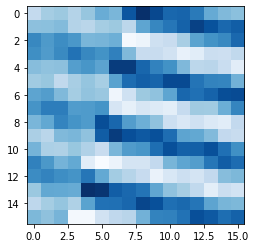

In [20]:
a = file_a[1].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

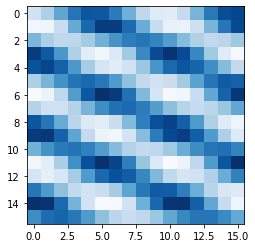

In [21]:
a = file_a[99].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

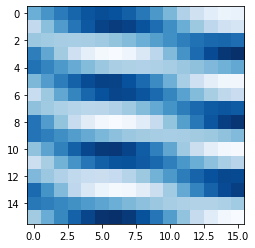

In [22]:
a = file_a[90].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

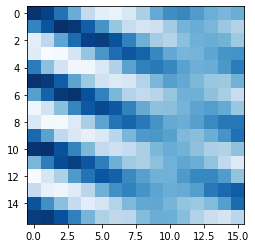

In [23]:
a = file_a[80].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

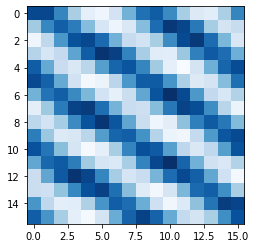

In [24]:
a = file_a[70].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

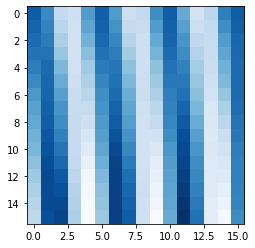

In [25]:
a = file_a[60].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

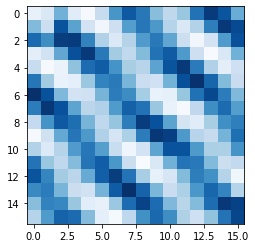

In [26]:
a = file_a[50].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

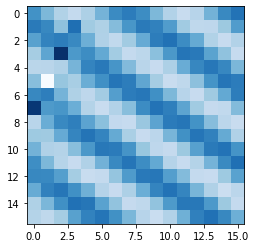

In [27]:
a = file_a[40].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

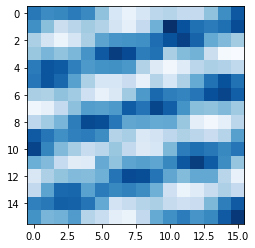

In [28]:
a = file_a[30].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

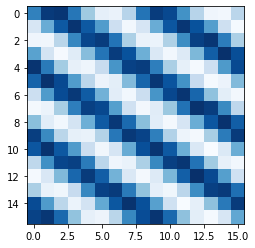

In [29]:
a = file_a[20].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')

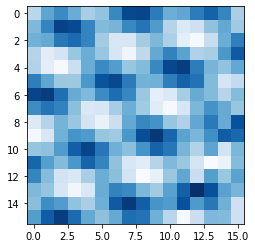

In [30]:
a = file_a[10].reshape(16,16)
plt.imshow(np.real(a),cmap = 'Blues')